<a href="https://colab.research.google.com/github/sohamazing/colorize/blob/main/colorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural network for colorizing grayscale images

**Author:** [Soham Mukherjee](soham1202@gmail.com)<br>
**Date created:** 12/20/2023<br>
**Last modified:** 12/20/2021<br>
**Description:** Train a deep convolutional network for colorizing a grayscale image.

# Introduction

This example demonstrates how to implement a deep convolutional network
for generating colors on a grayscale image.

# 1. Peliminaries

## Setup tensorflow

In [ ]:
# Tensorflow setup - one-time (if needed)

# To determine which version you're using:
# !pip show tensorflow

# For the current version:
# !pip install --upgrade tensorflow

# For the latest nightly build (if needed):
# !pip install tf-nightly


## Needed imports

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from io import BytesIO
import requests
import scipy.ndimage

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow import pad
from google.colab import drive

# whether to load npz files from url or gdrive path
use_url = True


# 2. Various Setup and helper utilities

## Utilities to load npz data files from url or local gdrive

In [ ]:
def load_url(url):
    """
    Load npz file from a url
    """
    r = requests.get(url, stream = True)
    with np.load(BytesIO(r.raw.read())) as f:
      y_data, uv_data = (f['y_array'], f['uv_array'])

    return y_data, uv_data


def load_gdrive_path(path):
    """
    Load npz file from a gdrive path
    """
    drive.mount('/content/gdrive', force_remount=True)

    with np.load(test_path) as f:
      y_data, uv_data = (f['y_array'], f['uv_array'])

    return y_data, uv_data

## Utilities for displaying gray and dolor patches, including conversion from YUV to RGB.

In [ ]:
from scipy import ndimage

def ConvertYUVtoRGB(plane_y, plane_u, plane_v):

  height = plane_y.shape[0]
  width  = plane_y.shape[1]

  height2 = plane_u.shape[0]
  width2 = plane_u.shape[1]

  # upsample if YV12
  if height2 * 2 == height and width2 * 2 == width:
    plane_u = ndimage.zoom(plane_u, 2, order=1)
    plane_v = ndimage.zoom(plane_v, 2, order=1)

  # reshape
  plane_y  = plane_y.reshape((plane_y.shape[0], plane_y.shape[1], 1))
  plane_u  = plane_u.reshape((plane_u.shape[0], plane_u.shape[1], 1))
  plane_v  = plane_v.reshape((plane_v.shape[0], plane_v.shape[1], 1))

  # make YUV of shape [height, width, color_plane]
  yuv = np.concatenate((plane_y, plane_u, plane_v), axis=2)

  yuv = yuv.astype(np.float32)
  yuv[:, :, 0] = yuv[:, :, 0].clip(16, 235) - 16
  yuv[:, :, 1:] = yuv[:, :, 1:].clip(16, 240) - 128

  #A = np.array([[1, 0, 1.13983],
  #              [1, -0.39465, -0.5806],
  #              [1, 2.03211, 0]])

  A = np.array([[1.164,  0.000,  1.596],
                [1.164, -0.392, -0.813],
                [1.164,  2.017,  0.000]])

  # The final result
  rgb = np.dot(yuv, A.T).clip(0, 255).astype('uint8')

  return rgb


def display2(y_data, uv_data, patchsize):
    """
    Displays 12 random images from each one of the supplied arrays.
    """
    n = 12
    indices = np.random.randint(len(y_data), size=n)
    y_list = y_data[indices, :]
    uv_list = uv_data[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (y_sample, uv_sample) in enumerate(zip(y_list, uv_list)):
        ax = plt.subplot(2, n, i + 1)
        y = y_sample.reshape(patchsize, patchsize)
        plt.imshow(y, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        uv = uv_sample.reshape(patchsize // 2, patchsize // 2, 2)
        u = uv[:, :, 0]
        v = uv[:, :, 1]
        rgb = ConvertYUVtoRGB(y, u, v)
        plt.imshow(rgb, cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def display3(y_data, uv_data, uv_data2, patchsize):
    """
    Displays 12 random images from each one of the supplied arrays.
    """

    n = 12
    indices = np.random.randint(len(y_data), size=n)
    y_list = y_data[indices, :]
    uv_list = uv_data[indices, :]
    uv_list2 = uv_data2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (y_sample, uv_sample, uv_sample2) in enumerate(zip(y_list, uv_list, uv_list2)):
        ax = plt.subplot(3, n, i + 1)
        y = y_sample.reshape(patchsize, patchsize)
        plt.imshow(y, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        uv = uv_sample.reshape(patchsize // 2, patchsize // 2, 2)
        u = uv[:, :, 0]
        v = uv[:, :, 1]
        rgb = ConvertYUVtoRGB(y, u, v)
        plt.imshow(rgb)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        uv = uv_sample2.reshape(patchsize // 2, patchsize // 2, 2)
        u = uv[:, :, 0]
        v = uv[:, :, 1]
        rgb = ConvertYUVtoRGB(y, u, v)
        plt.imshow(rgb, cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Utilities for preprocessing to normalize all the uint8 YUV data in [0, 255] range to floats in [0.0, 1.0] range, as well as for post conversion of inferred float UV data in [0.0, 1.0] range to uint8 in the [0, 255] range.

In [ ]:
def preprocess(array, patchsize):
    """
    Normalizes the supplied array to the [0.0, 1.0] range.
    """
    array = array.astype("float32") / 255.0
    return array

def round_postpredict(array):
    """
    Rounds and clamps array from floating point [0.0, 1.0] range for source
    to 8-bit [0, 255] range after prediction by scaling by 255 and clamping.
    """
    array = np.ndarray.round(array * 255.0)
    array = np.clip(array, 0.0, 255.0)
    return array.astype("uint8")



## Utility for computing FLOPS and MACCs given a model.

In [ ]:
def net_flops(model, samples, table=False):
    """
    Estimator for model FLOPS in keras
    Use: net_flops(model, samples, table=False)
    Supported Layers:
      Conv2D, DepthwiseConv2D, SeparableConv2D, Activation,
      BatchNormalization, InputLayer, Reshape, Add, Maximum,
      Concatenate, Average, pool, Flatten, Global Pooling,
    """
    if (table == True):
        print('-' * 160)
        print('%25s | %16s | %16s | %12s | %12s | %8s | %12s | %12s' % (
            'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS', 'MACC'))
        print('-' * 160)

    t_flops = 0
    t_macc = 0

    for l in model.layers:

        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if ('InputLayer' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if ('Reshape' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if ('Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('Average' in str(l) and 'pool' not in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('BatchNormalization' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('Activation' in str(l) or 'activation' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('pool' in str(l) and ('Global' not in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if ('Flatten' in str(l)):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if ('Dense' in str(l)):
            print(l.input)
            i_shape = l.input.shape[1:4].as_list()[0]
            if (i_shape == None):
                i_shape = out_vec

            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if ('Padding' in str(l)):
            flops = 0

        if (('Global' in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        t_macc += macc

        t_flops += flops

        if (table == True):
            print('%25s | %16s | %16s | %12s | %12s | %8s | %12s | %12s' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), str(flops), str(macc)))
    t_flops_per_sample = t_flops / samples
    t_macc_per_sample = t_macc / samples

    print('\nTotal FLOPS/sample: %10.4f\n' % (t_flops_per_sample))
    print('\nTotal MACCs/sample: %10.4f\n' % (t_macc_per_sample))

    return (t_flops_per_sample, t_macc_per_sample)

# 3. Train CNN

## Load Training Set, split Training Set into Validation Set. Visualize patches.

In [ ]:
if use_url:
  train_url = 'https://storage.googleapis.com/colorizedata/colorize_train32.npz'
  y_train, uv_train = load_url(train_url)
else:
  train_path = 'gdrive/My Drive/Colab Notebooks/colorize_train32.npz'
  y_train, uv_train = load_gdrive_path(train_path)


# Get patchsize
patchsize = y_train.shape[1]

# Split a fraction of the training set into a validation set
valid_split_ratio = 0.15
nvalid = int(len(y_train) * valid_split_ratio)

y_valid = y_train[0:nvalid]
y_train = y_train[nvalid:]
uv_valid = uv_train[0:nvalid]
uv_train = uv_train[nvalid:]


print('Training   size:', y_train.shape, uv_train.shape)
print('Validation size:', y_valid.shape, uv_valid.shape)
print('patchsize: ', patchsize)

# Normalize and reshape the data
y_train_norm = preprocess(y_train, patchsize)
uv_train_norm = preprocess(uv_train, patchsize)
y_valid_norm = preprocess(y_valid, patchsize)
uv_valid_norm = preprocess(uv_valid, patchsize)


Training   size: (58814, 32, 32) (58814, 16, 16, 2)
Validation size: (10378, 32, 32) (10378, 16, 16, 2)
Testdata   size: (69192, 32, 32) (69192, 16, 16, 2)
patchsize:  32


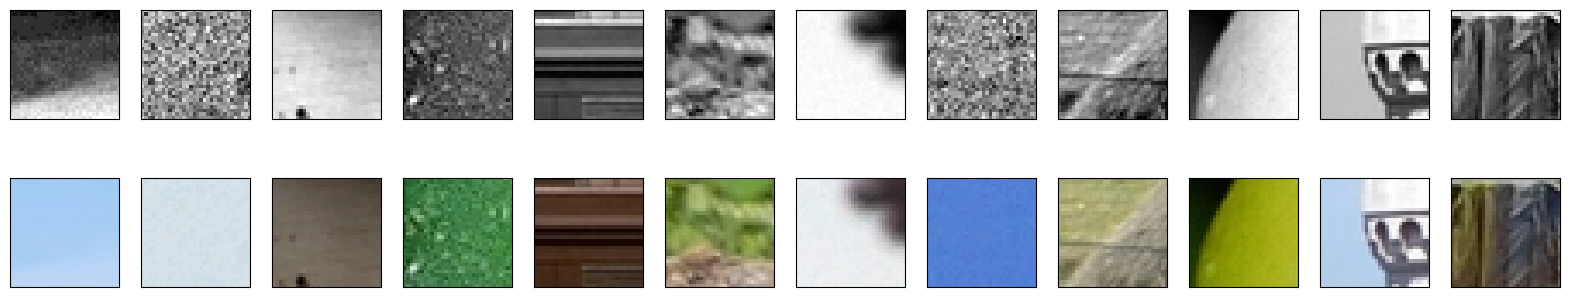

In [ ]:
# Display the train data and a noisy version of it
display2(y_train, uv_train, patchsize)

## Build the CNN and analyze its complexity

We are going to use the Functional API to build our convolutional neural network.

In [ ]:
def generate_cnn(input_size=None):

  my_learning_rate = 0.0002

  input = layers.Input(shape=(input_size, input_size, 1))

  x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(input)
  x = layers.Conv2D(32, (5, 5), activation="relu", strides=(2, 2), padding="same")(x)
  x = layers.Conv2D(16, (5, 5), activation="relu", padding="same")(x)
  x = layers.Conv2D(8, (5, 5), activation="relu", padding="same")(x)
  output = layers.Conv2D(2, (5, 5), activation="sigmoid", padding="same")(x)

  # CNN
  cnn = Model(input, output)
  cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=['mse'])

  return cnn


my_cnn = generate_cnn()
my_cnn.summary()

# To get FLOPS need to use a model with any non-None input shape
# Then to get flops per pixel divide by number of pixels
my_cnn2 = generate_cnn(patchsize)
(_, _) = net_flops(my_cnn2, patchsize * patchsize, table=True)


Model: "model_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_356 (Conv2D)         (None, None, None, 32)    832       
                                                                 
 conv2d_357 (Conv2D)         (None, None, None, 32)    25632     
                                                                 
 conv2d_358 (Conv2D)         (None, None, None, 16)    12816     
                                                                 
 conv2d_359 (Conv2D)         (None, None, None, 8)     3208      
                                                                 
 conv2d_360 (Conv2D)         (None, None, None, 2)     402       
                                                                 
Total params: 42890 (167.54 KB)
Trainable params: 42890 (1

## Launch training

Now that we have our network, let's train it using the Y training
data as our input and the UV training data as our target. We want our CNN to learn how to generate UV channels from the Y data only.

In [ ]:
# Mount your Google drive to write the model generated
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
model_out  = 'gdrive/My Drive/Colab Notebooks/colorizeA.keras'

# Train network
my_cnn.fit(
    x=y_train_norm,
    y=uv_train_norm,
    epochs=50,
    batch_size=1024,
    shuffle=True,
    validation_data=(y_valid_norm, uv_valid_norm),
)

# Save trained network
my_cnn.save(model_out)

Mounted at /content/gdrive
Epoch 1/50
58/58 [==============================] - 3s 60ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 2/50
58/58 [==============================] - 3s 56ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/50
58/58 [==============================] - 3s 58ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 6/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/50
58/58 [==============================] - 3s 58ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/50
58/58 [==============================] - 3s 5

# 4. Test our CNN

Note that this part can be run independently of the Train CNN part above as long as we have the model saved in our gdrive, and we have a test set NPZ.

## Load the test data

In [ ]:
# Load test data
if use_url:
  test_url = 'https://storage.googleapis.com/colorizedata/colorize_test32.npz'
  y_test, uv_test = load_url(test_url)
else:
  test_path = 'gdrive/My Drive/Colab Notebooks/colorize_test32.npz'
  y_test, uv_test = load_gdrive_path(test_path)

## Run the inference on the Y test data to generate UV data. Visualize ground-truth color patches vs. generated color patches. Compute mse.

Mounted at /content/gdrive
2163/2163 [==============================] - 4s 2ms/step


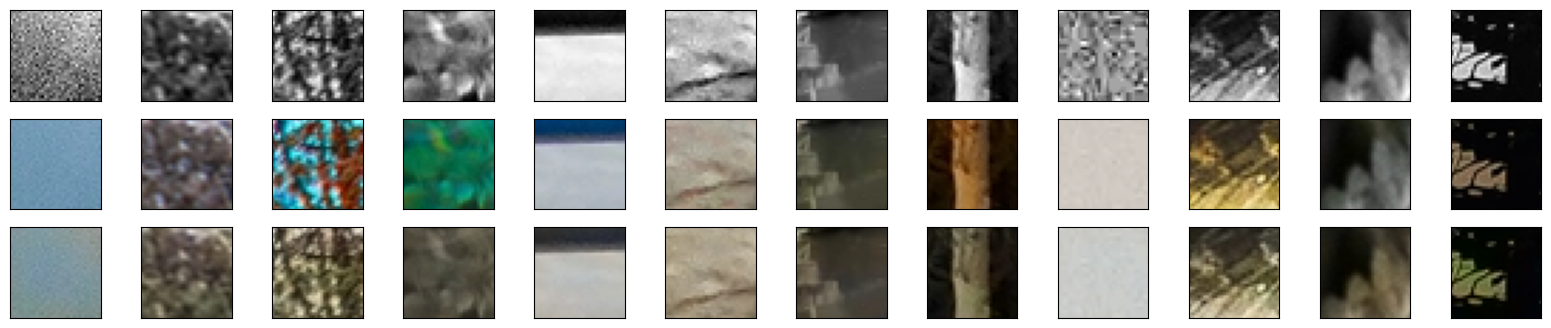

Test Generated UV MSE: 185
Reference UV MSE (assuming 128 for U & V): 257


In [ ]:
# Utility to compute MSE between two tensors
def get_mse(x, y):
    """
    Gets mse of two tensors of size [batchize, height, width, channels]
    """
    mse = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    return mse(x.astype(int), y.astype(int)).numpy()


# Test colorization
def test_my_cnn(my_cnn, y_test, uv_test):

    patchsize = y_test.shape[1]

    # Preprocess the y test data
    y_test_norm = preprocess(y_test, patchsize)

    # Generate the uv colors
    uv_test_gen = round_postpredict(my_cnn.predict(y_test_norm))
    display3(y_test, uv_test, uv_test_gen, patchsize)

    # Compute MSE between real and generated UV
    loss_gen = get_mse(uv_test, uv_test_gen)
    print('Test Generated UV MSE: ' + str(loss_gen))

    # Compute MSE between real and reference UV assuming 128
    loss_ref = get_mse(uv_test, np.ones(uv_test.shape) * 128)
    print('Reference UV MSE (assuming 128 for U & V): ' + str(loss_ref))

# Load pre-trained model
drive.mount('/content/gdrive', force_remount=True)
model_out  = 'gdrive/My Drive/Colab Notebooks/colorizeA.keras'

test_cnn = tf.keras.models.load_model(model_out)
test_my_cnn(test_cnn, y_test, uv_test)